In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Overview
- This notebook describes an example where the kmeans algorithm does **NOT** work well due to its **spherical assumption**.  
- First, I will test the kmeans algorithm (+elbow method) to see if the famous iris data can be classified by clustering in unsupervised learning.
- Next, I will explain why kmeans does not work well for iris data and then explain GMM algorithm as an alternative option.


In [9]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
series1 = pd.Series(data=[iris.target_names[i] for i in iris.target], name="kind")
df = pd.concat([df,series1], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),kind
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

my_numeric_scaler = make_pipeline(
    StandardScaler(),
    PCA(n_components=4)
)

preprocessor_list = [
    ("drop_features", "drop", []),
    ('numeric_scaler_features', my_numeric_scaler, ['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']),
    ("passthrough_features", "passthrough", ["kind"]),
]
my_preprocessor = ColumnTransformer(
    preprocessor_list,
    remainder='drop' # removing target variable
)
df_trans = Pipeline([
    ("preprocessor", my_preprocessor)
]
).fit_transform(df)
df_trans = pd.DataFrame(df_trans, columns=['PC1', 'PC2', 'PC3', 'PC4', 'kind'])
display(df_trans.head())


,PC1,PC2,PC3,PC4,kind
0,-2.264703,0.480027,-0.127706,-0.024168,setosa
1,-2.080961,-0.674134,-0.234609,-0.103007,setosa
2,-2.364229,-0.341908,0.044201,-0.028377,setosa
3,-2.299384,-0.597395,0.09129,0.065956,setosa
4,-2.389842,0.646835,0.015738,0.035923,setosa


### 累積寄与率・変数別寄与率

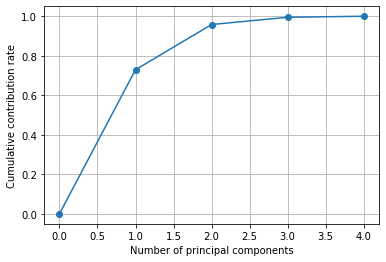

In [4]:
import numpy as np

tgt_cols = ['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
scaler = StandardScaler()
df_tmp = scaler.fit_transform(df[tgt_cols])
pca = PCA(n_components=4)
df_tmp_pca = pca.fit_transform(df_tmp)

plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

### 主成分固有ベクトル

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
PC1,0.521066,-0.269347,0.580413,0.564857
PC2,0.377418,0.923296,0.024492,0.066942
PC3,-0.719566,0.244382,0.142126,0.634273
PC4,-0.261286,0.123510,0.801449,-0.523597


<AxesSubplot:>

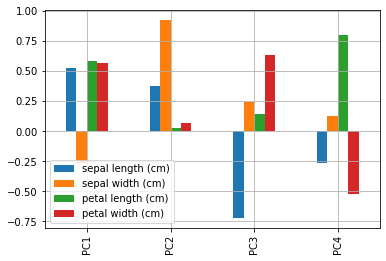

In [5]:
dfpca_eigen = pd.DataFrame(pca.components_, columns=tgt_cols, index=["PC{}".format(x + 1) for x in range(len(tgt_cols))])
display(dfpca_eigen)
dfpca_eigen.plot.bar(grid=True)

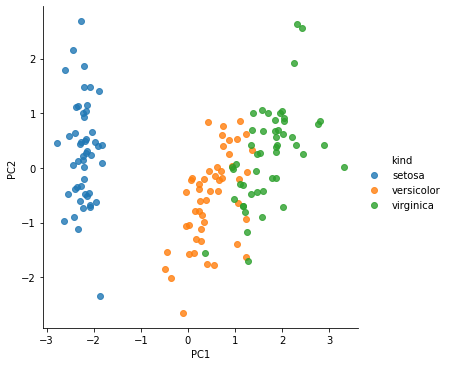

In [11]:
# plt.scatter(df_trans['PC1'], df_trans['PC2'])
sns.lmplot( x="PC1", y="PC2", data=df_trans, fit_reg=False, hue='kind', legend=True)
plt.show()

### Kmeans w/ Elbow method
 - caluculate WCSS(within cluster sum of suquares (of distance between centroid and sample)

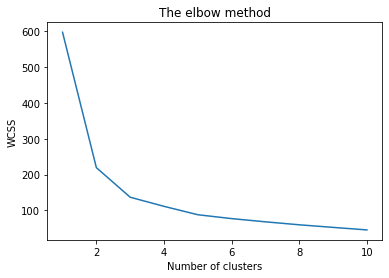

In [12]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 10 + 1):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_trans[['PC1', 'PC2', 'PC3']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares　
plt.show()

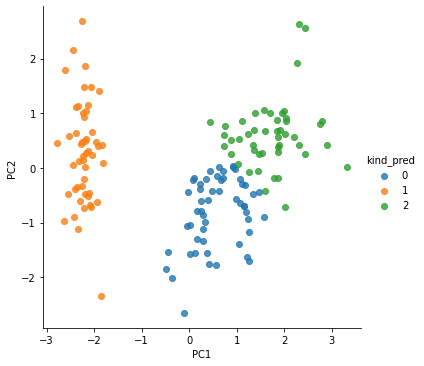

In [8]:
kmeans = KMeans(n_clusters=3)
y_pred = kmeans.fit_predict(df_trans[['PC1', 'PC2', 'PC3']])
df_trans['kind_pred'] = kmeans.fit_predict(df_trans[['PC1', 'PC2', 'PC3']])

sns.lmplot( x="PC1", y="PC2", data=df_trans, fit_reg=False, hue='kind_pred', legend=True)
plt.show()


# Result
- Due to kmeans' spherical assumption, 'versicolor' and 'virginica' were separated into to sphere.
- For data with strong correlations between features, kmeans is not a good choice for clustering because the clusters will not be spherical in shape. 
- In this case, the GMM algorithm, described in the 'sklearn_GMM_clustering_iris', is effective (but it is much computationary rich)